In [100]:
from astropathdb import AstroDB, load_astrosample #database analysis
from sidus import plotting as pl #to visualize the image
from sidus import tools as tl  #import editing tools
from sidus import io #import input/output tools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ants 
import spatialdata as sd
import xarray as xr
import dask.array as da
from spatialdata import get_extent 
import itertools
from sklearn.metrics import jaccard_score, f1_score
from scipy.spatial.distance import directed_hausdorff
import SimpleITK as sitk
from skimage import exposure


Load clinical data

In [57]:
#Load the axis,regression and tbet clinical data
NAT_samples = pd.read_csv('C:/Users/molanre1/Desktop/WSIFIR/NAT_samples_12.2024.csv') #Change the path to your file
NAT_samples.head(5)

,redcapid,sampleid,slideid,tbet_sampleid,tbet_slideid,reg_sampleid,reg_slideid,RFS,recurrence,lastfollowup,...,analysis_area,specimen_collection,included,paired,model_rvt,ln_status,tumor,regression,good_tissue,pseudo_patient_id
0,239,101,L1_2,834.0,AP0140001,709.0,LY1,83,1.0,2022-11-10 00:00:00,...,59.987766,Post,1,1,0.0,1,1,0,1,1
1,240,107,L2_4,835.0,AP0140002,710.0,LY2,2,0.0,2016-05-01 00:00:00,...,83.479162,Post,1,1,2.0,0,1,1,1,2
2,242,535,L4_3,837.0,AP0140004,712.0,LY4,34,0.0,2019-03-13 00:00:00,...,25.146146,Post,1,1,0.0,0,0,1,1,4
3,243,112,L5_1,838.0,AP0140005,713.0,LY5,47,0.0,2021-07-04 00:00:00,...,52.582683,Post,1,0,0.0,0,0,1,1,5
4,244,114,L6_1,839.0,AP0140006,714.0,LY6,51,0.0,2016-12-12 00:00:00,...,84.902509,Post,1,0,1.0,0,1,1,1,6


In [58]:
#Get corresponding images on each panel. Each row represents corresponding images
ids = NAT_samples[["sampleid","reg_sampleid","tbet_sampleid","slideid","reg_slideid","tbet_slideid"]]

axis_sampleid = NAT_samples['sampleid']
reg_sampleid = NAT_samples['reg_sampleid']
tbet_sampleid = NAT_samples['tbet_sampleid']
axis_slideid = NAT_samples['slideid']
reg_slideid = NAT_samples['reg_slideid']
tbet_slideid = NAT_samples['tbet_slideid']

#Drop the rows with missing values
ids.dropna(inplace=True)


ids.head(46)

C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_17840\3763170471.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ids.dropna(inplace=True)


,sampleid,reg_sampleid,tbet_sampleid,slideid,reg_slideid,tbet_slideid
0,101,709.0,834.0,L1_2,LY1,AP0140001
1,107,710.0,835.0,L2_4,LY2,AP0140002
2,535,712.0,837.0,L4_3,LY4,AP0140004
3,112,713.0,838.0,L5_1,LY5,AP0140005
4,114,714.0,839.0,L6_1,LY6,AP0140006
5,118,715.0,840.0,L8_2,LY8,AP0140007
6,536,678.0,841.0,L9_3,AP0060001,AP0140008
7,537,679.0,842.0,L10_3,AP0060002,AP0140009
8,125,716.0,843.0,L11_3,LY11,AP0140010
9,129,717.0,844.0,L12_2,LY12,AP0140011


Load in images from the database

In [102]:
# Choose 3 rows to visualize (for example, row 0)
row_indexes = [0,1,2]

# List to store all images
all_images = []

# Dictionary to store the results of each iteration
results = {}

# Extract the row from the ids table
for row_index in row_indexes:
    selected_row = ids.iloc[row_index]

    # Create variables for each column in the selected row
    reg_sampleid = selected_row['reg_sampleid']
    tbet_sampleid = selected_row['tbet_sampleid']
    reg_slideid = selected_row['reg_slideid']
    tbet_slideid = selected_row['tbet_slideid']

    # Convert variables to integers
    reg_sampleid = int(reg_sampleid)
    tbet_sampleid = int(tbet_sampleid)

    # Print the variables to verify
    print(f"reg_sampleid: {reg_sampleid}")
    print(f"tbet_sampleid: {tbet_sampleid}")
    print(f"reg_slideid: {reg_slideid}")
    print(f"tbet_slideid: {tbet_slideid}\n")

    # Save the variables in the dictionary
    results[row_index] = {
        'reg_sampleid': reg_sampleid,
        'tbet_sampleid': tbet_sampleid,
        'slideid': axis_slideid,
        'reg_slideid': reg_slideid,
        'tbet_slideid': tbet_slideid
    }

    # Load the images
    reg_image = io.load_astropath(sampleid=reg_sampleid, sample_path=f'//bki-fs1/data02/Clinical_Specimen_10/{reg_slideid}', cell_expressions_path=False, cell_geoms_path=False,cell_annotations_path=False, modaility='astropath')
    tbet_image = io.load_astropath(sampleid=tbet_sampleid, sample_path=f'//bki-fs1/data02/Clinical_Specimen_12/{tbet_slideid}', cell_expressions_path=False, cell_geoms_path=False,cell_annotations_path=False, modaility='astropath')

     # Add images to the list
    all_images.extend([reg_image, tbet_image])

# Load the project with all images
sp = io.load_project(samples=all_images, merge_tables=True, modality='astropath')

reg_sampleid: 709
tbet_sampleid: 834
reg_slideid: LY1
tbet_slideid: AP0140001

reg_sampleid: 710
tbet_sampleid: 835
reg_slideid: LY2
tbet_slideid: AP0140002

reg_sampleid: 712
tbet_sampleid: 837
reg_slideid: LY4
tbet_slideid: AP0140004



In [103]:
#Display the spatial data
sp

SpatialData object
├── Images
│     ├── 'sampleid_709_image': DataTree[cyx] (8, 65536, 49152), (8, 32768, 24576), (8, 16384, 12288), (8, 8192, 6144), (8, 4096, 3072), (8, 2048, 1536), (8, 1024, 768), (8, 512, 384), (8, 256, 192), (8, 128, 96)
│     ├── 'sampleid_710_image': DataTree[cyx] (8, 65536, 49152), (8, 32768, 24576), (8, 16384, 12288), (8, 8192, 6144), (8, 4096, 3072), (8, 2048, 1536), (8, 1024, 768), (8, 512, 384), (8, 256, 192), (8, 128, 96)
│     ├── 'sampleid_712_image': DataTree[cyx] (8, 65536, 49152), (8, 32768, 24576), (8, 16384, 12288), (8, 8192, 6144), (8, 4096, 3072), (8, 2048, 1536), (8, 1024, 768), (8, 512, 384), (8, 256, 192), (8, 128, 96)
│     ├── 'sampleid_834_image': DataTree[cyx] (8, 49152, 65536), (8, 24576, 32768), (8, 12288, 16384), (8, 6144, 8192), (8, 3072, 4096), (8, 1536, 2048), (8, 768, 1024), (8, 384, 512), (8, 192, 256), (8, 96, 128)
│     ├── 'sampleid_835_image': DataTree[cyx] (8, 49152, 65536), (8, 24576, 32768), (8, 12288, 16384), (8, 6144, 8192)

In [104]:
# Loop through each image in sp.images and crop it
cropped_images = {}
for sampleid in sp.images:
    cropped_images[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=9)[0]

In [108]:
##Create a dataframe with a columnn named panel that loops either axis, regression and tbet 3 time

panel = ['regression','tbet']*3

panel_df = pd.DataFrame(panel, columns=['panel'])

#Create a dataframe with a columnn named panel that loops either axis, regression and tbet 3 time

panel = ['regression','tbet']*3

panel_df = pd.DataFrame(panel, columns=['panel'])


#Save dimensions of the cropped images to a dataframe


cropped_images_dimensions = {}
for sampleid, cropped_image in cropped_images.items():
    cropped_images_dimensions[sampleid] = {
        'dimensions': cropped_image.shape,
        'data_type': cropped_image.dtype,
        'coordinates': cropped_image.coords
    }
#Convert to dataframe
cropped_images_dimensions_df = pd.DataFrame.from_dict(cropped_images_dimensions, orient='index')

#Add the panel column to the dataframe

cropped_images_dimensions_df['panel'] = panel_df['panel'].values


In [109]:
cropped_images_dimensions_df

,dimensions,data_type,coordinates,panel
sampleid_709_image,"(128, 96)",float32,"[c, y, x]",regression
sampleid_834_image,"(96, 128)",float32,"[c, y, x]",tbet
sampleid_710_image,"(128, 96)",float32,"[c, y, x]",regression
sampleid_835_image,"(96, 128)",float32,"[c, y, x]",tbet
sampleid_712_image,"(128, 96)",float32,"[c, y, x]",regression
sampleid_837_image,"(96, 128)",float32,"[c, y, x]",tbet


In [113]:
#Get all the keys in the cropped_images dictionary
reg_name_1 = list(cropped_images.keys())[0]
tbet_name_1 = list(cropped_images.keys())[1]

reg_name_2 = list(cropped_images.keys())[2]
tbet_name_2 = list(cropped_images.keys())[3]

reg_name_3 = list(cropped_images.keys())[4]
tbet_name_3 = list(cropped_images.keys())[5]

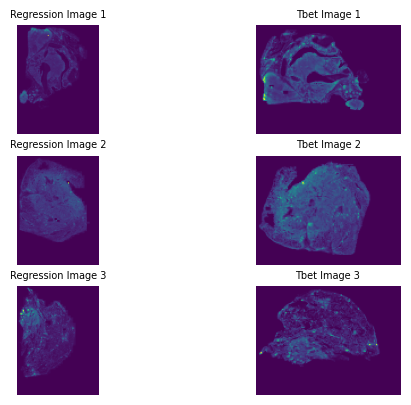

In [114]:

# Plot the images


plt.subplot(3,2,1)
plt.imshow(cropped_images[f'{reg_name_1}'].compute())
plt.title('Regression Image 1',fontsize=7)
plt.axis('off')
plt.subplot(3,2,2)
plt.imshow(cropped_images[f'{tbet_name_1}'].compute())
plt.title('Tbet Image 1',fontsize=7)
plt.axis('off')
plt.subplot(3,2,3)
plt.imshow(cropped_images[f'{reg_name_2}'].compute())
plt.title('Regression Image 2',fontsize=7)
plt.axis('off')
plt.subplot(3,2,4)
plt.imshow(cropped_images[f'{tbet_name_2}'].compute())
plt.title('Tbet Image 2',fontsize=7)
plt.axis('off')
plt.subplot(3,2,5)
plt.imshow(cropped_images[f'{reg_name_3}'].compute())
plt.title('Regression Image 3',fontsize=7)
plt.axis('off')
plt.subplot(3,2,6)
plt.imshow(cropped_images[f'{tbet_name_3}'].compute())
plt.title('Tbet Image 3 ',fontsize=7)
plt.axis('off')

plt.show()


In [ ]:
#Rigid, affine, deformable registration on the same 2 images.
#Then do the same for the composite and 3rd image
#3 > 2 , 1 >2, all in the same coordinate system

In [21]:
#Convert the cropped images to ants
axis_image_cropped_ants_1 = ants.from_numpy(cropped_images[f'sampleid_{results[0]["axis_sampleid"]}_image'].compute().data)
reg_image_cropped_ants_1 = ants.from_numpy(cropped_images[f'sampleid_{results[0]["reg_sampleid"]}_image'].compute().data)

axis_image_cropped_ants_2 = ants.from_numpy(cropped_images[f'sampleid_{results[1]["axis_sampleid"]}_image'].compute().data)
reg_image_cropped_ants_2 = ants.from_numpy(cropped_images[f'sampleid_{results[1]["reg_sampleid"]}_image'].compute().data)

axis_image_cropped_ants_3 = ants.from_numpy(cropped_images[f'sampleid_{results[2]["axis_sampleid"]}_image'].compute().data)
reg_image_cropped_ants_3 = ants.from_numpy(cropped_images[f'sampleid_{results[2]["reg_sampleid"]}_image'].compute().data)


In [22]:
#Pad the images so they are the same size
reg_image_cropped_shape_1 = reg_image_cropped_ants_1.shape
axis_image_cropped_shape_1= axis_image_cropped_ants_1.shape

reg_image_cropped_shape_2 = reg_image_cropped_ants_2.shape
axis_image_cropped_shape_2= axis_image_cropped_ants_2.shape

reg_image_cropped_shape_3 = reg_image_cropped_ants_3.shape
axis_image_cropped_shape_3= axis_image_cropped_ants_3.shape

#Get the target shapes for padding
target_shape_1_x = max(reg_image_cropped_shape_1[0],axis_image_cropped_shape_1[0])
target_shape_1_y = max(reg_image_cropped_shape_1[1],axis_image_cropped_shape_1[1])

target_shape_2_x = max(reg_image_cropped_shape_2[0],axis_image_cropped_shape_2[0])
target_shape_2_y = max(reg_image_cropped_shape_2[1],axis_image_cropped_shape_2[1])

target_shape_3_x = max(reg_image_cropped_shape_3[0],axis_image_cropped_shape_3[0])
target_shape_3_y = max(reg_image_cropped_shape_3[1],axis_image_cropped_shape_3[1])

#Calculate the padding
pad_reg_X_1 = (0,target_shape_1_x-reg_image_cropped_shape_1[0])
pad_reg_Y_1 = (0,target_shape_1_y-reg_image_cropped_shape_1[1])

pad_reg_X_2 = (0,target_shape_2_x-reg_image_cropped_shape_2[0])
pad_reg_Y_2 = (0,target_shape_2_y-reg_image_cropped_shape_2[1])

pad_reg_X_3 = (0,target_shape_3_x-reg_image_cropped_shape_3[0])
pad_reg_Y_3 = (0,target_shape_3_y-reg_image_cropped_shape_3[1])



# Pad the cropped images to match the size of the rigid transformed images
reg_image_cropped_ants_1_padded = ants.pad_image(reg_image_cropped_ants_1, (target_shape_1_x,target_shape_1_y))
reg_image_cropped_ants_2_padded = ants.pad_image(reg_image_cropped_ants_2, (target_shape_2_x,target_shape_2_y))
reg_image_cropped_ants_3_padded = ants.pad_image(reg_image_cropped_ants_3, (target_shape_3_x,target_shape_3_y))


# Pad the axis images to match the size of the rigid transformed images
axis_image_cropped_ants_1_padded = ants.pad_image(axis_image_cropped_ants_1, (target_shape_1_x,target_shape_1_y))
axis_image_cropped_ants_2_padded = ants.pad_image(axis_image_cropped_ants_2, (target_shape_2_x,target_shape_2_y))
axis_image_cropped_ants_3_padded = ants.pad_image(axis_image_cropped_ants_3, (target_shape_3_x,target_shape_3_y))


# Print the shapes of the padded images
print("Padded axis image shape 1: ", axis_image_cropped_ants_1_padded.shape)
print("Padded axis image shape 2: ", axis_image_cropped_ants_2_padded.shape)
print("Padded axis image shape 3: ", axis_image_cropped_ants_3_padded.shape,"\n")

print("Padded regression image shape 1: ", reg_image_cropped_ants_1_padded.shape)
print("Padded regression image shape 2: ", reg_image_cropped_ants_2_padded.shape)
print("Padded regression image shape 3: ", reg_image_cropped_ants_3_padded.shape,"\n")




Padded axis image shape 1:  (128, 128)
Padded axis image shape 2:  (128, 128)
Padded axis image shape 3:  (128, 128) 

Padded regression image shape 1:  (128, 128)
Padded regression image shape 2:  (128, 128)
Padded regression image shape 3:  (128, 128) 



Regression to Axis Rigid Registration (Scale 9)

In [23]:
# Perform rigid registration first on the first image
rigid_result_1 = ants.registration(
    fixed=reg_image_cropped_ants_1_padded,
    moving=axis_image_cropped_ants_1_padded,
    type_of_transform='Rigid',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image1_'  # Descriptive outprefix
)

# Apply the rigid transformation to the first moving image
rigid_transformed_image_1 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_1_padded,
    moving=axis_image_cropped_ants_1_padded,
    transformlist=rigid_result_1['fwdtransforms']
)

# Perform rigid registration first on the second image
rigid_result_2 = ants.registration(
    fixed=reg_image_cropped_ants_2_padded,
    moving=axis_image_cropped_ants_2_padded,
    type_of_transform='Rigid',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image2_'  # Descriptive outprefix
)

# Apply the rigid transformation to the second moving image
rigid_transformed_image_2 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_2_padded,
    moving=axis_image_cropped_ants_2_padded,
    transformlist=rigid_result_2['fwdtransforms']
)

# Perform rigid registration first on the third image
rigid_result_3 = ants.registration(
    fixed=reg_image_cropped_ants_3_padded,
    moving=axis_image_cropped_ants_3_padded,
    type_of_transform='Rigid',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image3_'  # Descriptive outprefix
)

# Apply the rigid transformation to the third moving image
rigid_transformed_image_3 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_3_padded,
    moving=axis_image_cropped_ants_3_padded,
    transformlist=rigid_result_3['fwdtransforms']
)

antsRegistration -d 2 -r [000002608B1F91A8,000002608B1FB808,1] -m mattes[000002608B1F91A8,000002608B1FB808,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\rigid_registration_image1_,000002608B1FBEC8,000002608B1FB488] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [000002608B1FBDE8,000002608B1F91A8,1] -m mattes[000002608B1FBDE8,000002608B1F91A8,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\rigid_registration_image2_,000002608B1FB548,000002608B1FBEC8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [000002608B1FABA8,000002608B1FBDE8,1] -m mattes[000002608B1FABA8,000002608B1FBDE8,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\rigid_registration_image3_,000002608B1FABE8,000002608B1FB548] -x [NA,NA] -

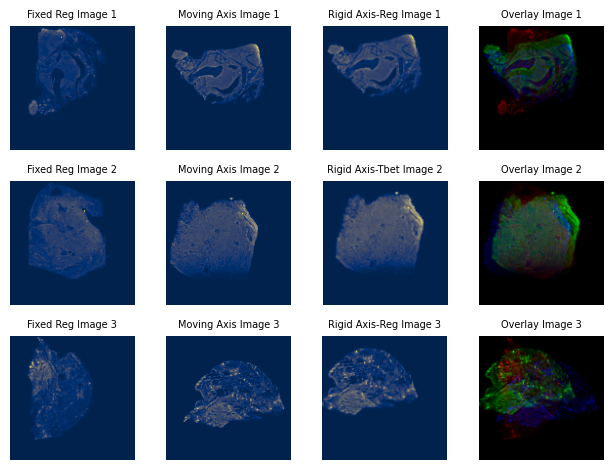

In [24]:
# Visualize the results
plt.subplot(3,4,1)
plt.imshow(reg_image_cropped_ants_1_padded.numpy(),cmap='cividis')
plt.title(f'Fixed Reg Image 1', fontsize=7)
plt.axis('off')

plt.subplot(3,4,2)
plt.imshow(axis_image_cropped_ants_1_padded.numpy(),cmap='cividis')
plt.title(f'Moving Axis Image 1', fontsize=7)
plt.axis('off')

plt.subplot(3,4,3)
plt.imshow(rigid_result_1['warpedmovout'].numpy(),cmap='cividis')
plt.title('Rigid Axis-Reg Image 1', fontsize=7)
plt.axis('off')

# Overlay for the first image
plt.subplot(3, 4, 4)
fixed_1 = exposure.rescale_intensity(reg_image_cropped_ants_1_padded.numpy(), out_range=(0, 1))
moving_1 = exposure.rescale_intensity(axis_image_cropped_ants_1_padded.numpy(), out_range=(0, 1))
registered_1 = exposure.rescale_intensity(rigid_result_1['warpedmovout'].numpy(), out_range=(0, 1))
overlay_1 = np.stack([fixed_1, registered_1, moving_1], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_1)
plt.title('Overlay Image 1', fontsize=7)
plt.axis('off')

plt.subplot(3,4,5)
plt.imshow(reg_image_cropped_ants_2_padded.numpy(),cmap='cividis')
plt.title(f'Fixed Reg Image 2', fontsize=7)
plt.axis('off')

plt.subplot(3,4,6)
plt.imshow(axis_image_cropped_ants_2_padded.numpy(),cmap='cividis')
plt.title(f'Moving Axis Image 2', fontsize=7)
plt.axis('off')

plt.subplot(3,4,7)
plt.imshow(rigid_result_2['warpedmovout'].numpy(),cmap='cividis')
plt.title('Rigid Axis-Tbet Image 2', fontsize=7)
plt.axis('off')

# Overlay for the second image
plt.subplot(3, 4, 8)
fixed_2 = exposure.rescale_intensity(reg_image_cropped_ants_2_padded.numpy(), out_range=(0, 1))
moving_2 = exposure.rescale_intensity(axis_image_cropped_ants_2_padded.numpy(), out_range=(0, 1))
registered_2 = exposure.rescale_intensity(rigid_result_2['warpedmovout'].numpy(), out_range=(0, 1))
overlay_2 = np.stack([fixed_2, registered_2,  moving_2], axis=-1)  # Red for fixed, Blue for moving, Green for registered
plt.imshow(overlay_2)
plt.title('Overlay Image 2', fontsize=7)
plt.axis('off')



plt.subplot(3,4,9)
plt.imshow(reg_image_cropped_ants_3_padded.numpy(),cmap='cividis')
plt.title(f'Fixed Reg Image 3', fontsize=7)
plt.axis('off')

plt.subplot(3,4,10)
plt.imshow(axis_image_cropped_ants_3_padded.numpy(),cmap='cividis')
plt.title(f'Moving Axis Image 3', fontsize=7)
plt.axis('off')

plt.subplot(3,4,11)
plt.imshow(rigid_result_3['warpedmovout'].numpy(),cmap='cividis')
plt.title('Rigid Axis-Reg Image 3',fontsize=7)
plt.axis('off')

# Overlay for the third image
plt.subplot(3,4,12)
fixed_3 = exposure.rescale_intensity(reg_image_cropped_ants_3_padded.numpy(), out_range=(0, 1))
moving_3 = exposure.rescale_intensity(axis_image_cropped_ants_3_padded.numpy(), out_range=(0, 1))
registered_3 = exposure.rescale_intensity(rigid_result_3['warpedmovout'].numpy(), out_range=(0, 1))
overlay_3 = np.stack([fixed_3,registered_3, moving_3], axis=-1)  # Red for fixed, Blue for moving, Green for registered
plt.imshow(overlay_3)
plt.title('Overlay Image 3', fontsize=7)
plt.axis('off')

plt.tight_layout()
plt.show()

In [25]:
#View image metadata

rigid_result_1 

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -16.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-16.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image1_0GenericAffine_scaled.mat',
  'C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image1_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image1_0GenericAffine.mat',
  'C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image1_0GenericAffine_scaled.mat']}

In [26]:
fwd_aff_1 = ants.read_transform(rigid_result_1['fwdtransforms'][0])
fwd_aff_1_parameters_np = np.array(fwd_aff_1.parameters)
fwd_aff_1_parameters_np

array([  0.99973816,   0.02288172,  -0.02288172,   0.99973816,
       -10.69653034,  20.24638748])

In [27]:
fwd_aff_1.fixed_parameters


array([41.98567581, 35.21538925])

In [28]:
rigid_result_2 

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -16.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-16.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image2_0GenericAffine_scaled.mat',
  'C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image2_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image2_0GenericAffine.mat',
  'C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image2_0GenericAffine_scaled.mat']}

In [29]:
fwd_aff_2 = ants.read_transform(rigid_result_2['fwdtransforms'][0])
fwd_aff_2_parameters_np = np.array(fwd_aff_2.parameters)
fwd_aff_2_parameters_np

array([  0.99876261,   0.04973175,  -0.04973175,   0.99876261,
       -15.31672859,   8.69376373])

In [31]:
fwd_aff_2.fixed_parameters

array([52.7854805 , 42.12069702])

In [32]:
rigid_result_3

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -16.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-16.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image3_0GenericAffine_scaled.mat',
  'C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image3_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image3_0GenericAffine.mat',
  'C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image3_0GenericAffine_scaled.mat']}

In [34]:
fwd_aff_3 = ants.read_transform(rigid_result_3['fwdtransforms'][0])
fwd_aff_3_parameters_np = np.array(fwd_aff_1.parameters)
fwd_aff_3_parameters_np


array([  0.99973816,   0.02288172,  -0.02288172,   0.99973816,
       -10.69653034,  20.24638748])

In [35]:
fwd_aff_3.fixed_parameters

array([50.77205276, 28.47519302])

In [36]:
#Metrics

#Compute mutual information between the fixed regression and  transformed axis-reg image 
mi1 = ants.image_mutual_information(reg_image_cropped_ants_1_padded,rigid_result_1['warpedmovout']) 
mi2 = ants.image_mutual_information(reg_image_cropped_ants_2_padded, rigid_result_2['warpedmovout'])   
mi3 = ants.image_mutual_information(reg_image_cropped_ants_3_padded, rigid_result_3['warpedmovout'])


#Compute normalized cross correlation between the fixed regression and  transformed axis-reg image 
cc1 = ants.math.image_similarity(reg_image_cropped_ants_1_padded,rigid_result_1['warpedmovout'], 'Correlation')
cc2 = ants.math.image_similarity(reg_image_cropped_ants_2_padded, rigid_result_2['warpedmovout'], 'Correlation')
cc3 = ants.math.image_similarity(reg_image_cropped_ants_3_padded, rigid_result_3['warpedmovout'], 'Correlation')

#Compute mean squares between the fixed regression and  transformed axis-reg image 
mse1 = ants.math.image_similarity(reg_image_cropped_ants_1_padded, rigid_result_1['warpedmovout'], 'MeanSquares')
mse2 = ants.math.image_similarity(reg_image_cropped_ants_2_padded, rigid_result_2['warpedmovout'], 'MeanSquares')
mse3 = ants.math.image_similarity(reg_image_cropped_ants_3_padded, rigid_result_3['warpedmovout'], 'MeanSquares')


In [40]:
# Binarize the arrays (threshold = 0.5)
reg_image_1_binary = (reg_image_cropped_ants_1_padded.numpy() > 0.5).astype(int)
reg_image_2_binary = (reg_image_cropped_ants_2_padded.numpy() > 0.5).astype(int)
reg_image_3_binary = (reg_image_cropped_ants_3_padded.numpy() > 0.5).astype(int)

rigid_result_1_binary = (rigid_result_1['warpedmovout'].numpy() > 0.5).astype(int)
rigid_result_2_binary = (rigid_result_2['warpedmovout'].numpy() > 0.5).astype(int)
rigid_result_3_binary = (rigid_result_3['warpedmovout'].numpy() > 0.5).astype(int)



# Compute Jaccard Index

jaccard_1 = jaccard_score(reg_image_1_binary.flatten(), rigid_result_1_binary.flatten())
jaccard_2 = jaccard_score(reg_image_2_binary.flatten(), rigid_result_2_binary.flatten())
jaccard_3 = jaccard_score(reg_image_3_binary.flatten(), rigid_result_3_binary.flatten())


# Compute Dice Similarity Score

dice1 = f1_score(reg_image_1_binary.flatten(), rigid_result_1_binary.flatten())
dice2 = f1_score(reg_image_2_binary.flatten(), rigid_result_2_binary.flatten())
dice3 = f1_score(reg_image_3_binary.flatten(), rigid_result_3_binary.flatten())


# Compute Hausdorff Distance using SimpleITK
sitk_initial_image_1 = sitk.GetImageFromArray(reg_image_cropped_ants_1_padded.numpy())
sitk_final_image_1 = sitk.GetImageFromArray(rigid_result_1['warpedmovout'].numpy())

sitk_initial_image_2 = sitk.GetImageFromArray(reg_image_cropped_ants_2_padded.numpy())
sitk_final_image_2 = sitk.GetImageFromArray(rigid_result_2['warpedmovout'].numpy())

sitk_initial_image_3 = sitk.GetImageFromArray(reg_image_cropped_ants_3_padded.numpy())
sitk_final_image_3 = sitk.GetImageFromArray(rigid_result_3['warpedmovout'].numpy())



# Compute Hausdorff Distance for axis image 1 and final image 1
hausdorff_filter_1 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_1.Execute(sitk_initial_image_1, sitk_final_image_1)
hausdorff_sitk_1 = hausdorff_filter_1.GetHausdorffDistance()

#Compute Hausdorff Distance for axis image 2 and final image 2
hausdorff_filter_2 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_2.Execute(sitk_initial_image_2, sitk_final_image_2)
hausdorff_sitk_2 = hausdorff_filter_2.GetHausdorffDistance()

#Compute Hausdorff Distance for axis image 3 and final image 3
hausdorff_filter_3 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_3.Execute(sitk_initial_image_3, sitk_final_image_3)
hausdorff_sitk_3 = hausdorff_filter_3.GetHausdorffDistance()



<Figure size 1000x600 with 0 Axes>

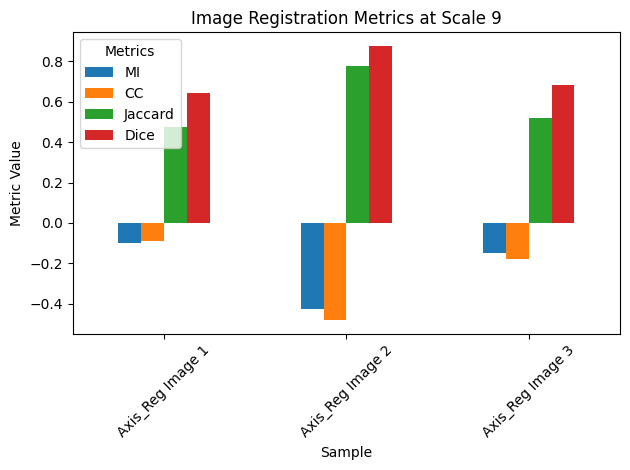

<Figure size 1000x600 with 0 Axes>

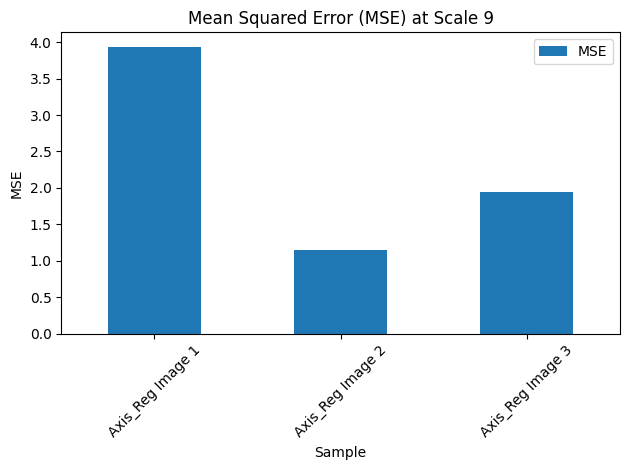

<Figure size 1000x600 with 0 Axes>

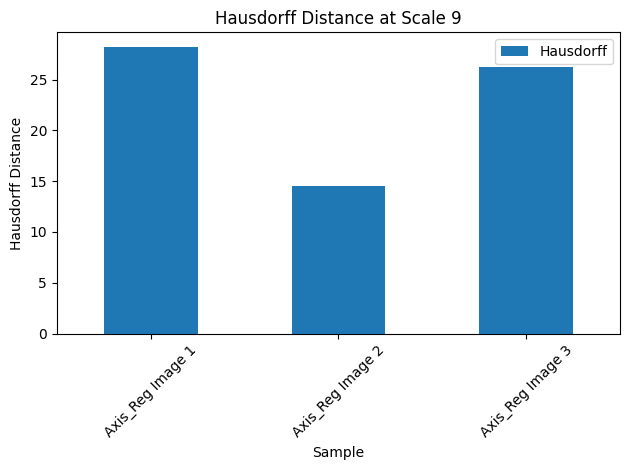

In [82]:
#Display the mi, cc, mse, jaccard, dice and hausdorff distance as graphs
metrics_df = pd.DataFrame({
    'Sample': ['Axis_Reg Image 1', 'Axis_Reg Image 2', 'Axis_Reg Image 3'],
    'MI': [mi1, mi2, mi3],
    'CC': [cc1, cc2, cc3],
    'MSE': [mse1, mse2, mse3],
    'Jaccard': [jaccard_1, jaccard_2, jaccard_3],
    'Dice': [dice1, dice2, dice3],
    'Hausdorff': [hausdorff_sitk_1, hausdorff_sitk_2, hausdorff_sitk_3]
})

# Set the index to the Sample ID
metrics_df.set_index('Sample', inplace=True)

# Plot the metrics minus hausdorff distance and mse
plt.figure(figsize=(10, 6))
metrics_df[['MI', 'CC', 'Jaccard', 'Dice']].plot(kind='bar')
plt.title('Image Registration Metrics at Scale 9')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

# Plot the Mean Squared Error (MSE)
plt.figure(figsize=(10, 6))
metrics_df[['MSE']].plot(kind='bar')
plt.title('Mean Squared Error (MSE) at Scale 9')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Plot the Hausdorff distance
plt.figure(figsize=(10, 6))
metrics_df[['Hausdorff']].plot(kind='bar')
plt.title('Hausdorff Distance at Scale 9')
plt.ylabel('Hausdorff Distance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [108]:
#Create dataframe to store the results

# Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 3 different slices representing the same tissue stained with the axis, regression and tbet panels
#Each different row represents a different tissue

row_1 = pd.DataFrame([results[0]])
row_2 = pd.DataFrame([results[1]])
row_3 = pd.DataFrame([results[2]])
                              

# Concatenate the rows into a single DataFrame
merged_df = pd.concat([row_1, row_2, row_3], ignore_index=True)

#Add columns to the merged DataFrame

merged_df['scale'] = [9,9,9]    
merged_df['final_image_fixed_parameters'] = [fwd_aff_1.fixed_parameters,fwd_aff_2.fixed_parameters,fwd_aff_3.fixed_parameters] 
merged_df['final_image_parameters'] = [fwd_aff_1.parameters,fwd_aff_2.parameters,fwd_aff_3.parameters] 
merged_df['mi_reg_transformed_axis'] = [mi1,mi2,mi3]
merged_df['cc_reg_transformed_axis'] = [cc1,cc2,cc3]
merged_df['mse_reg_transformed_axis'] = [mse1,mse2,mse3]
merged_df['jaccard_reg_transformed_axis'] = [jaccard_1,jaccard_2,jaccard_3]
merged_df['dice_reg_transformed_axis'] = [dice1,dice2,dice3]
merged_df['hausdorff_reg_transformed_axis'] = [hausdorff_sitk_1,hausdorff_sitk_2,hausdorff_sitk_3]   

merged_df

,axis_sampleid,reg_sampleid,tbet_sampleid,slideid,reg_slideid,tbet_slideid,scale,final_image_fixed_parameters,final_image_parameters,mi_reg_transformed_axis,cc_reg_transformed_axis,mse_reg_transformed_axis,jaccard_reg_transformed_axis,dice_reg_transformed_axis,hausdorff_reg_transformed_axis
0,101,709,834,L1_2,LY1,AP0140001,9,"[41.98567581176758, 35.215389251708984]","[0.9997381567955017, 0.02288171835243702, -0.0...",-0.100490,-0.087964,3.938794,0.473956,0.643107,28.231188
1,107,710,835,L2_4,LY2,AP0140002,9,"[52.78548049926758, 42.120697021484375]","[0.9987626075744629, 0.04973175376653671, -0.0...",-0.427114,-0.480190,1.142747,0.779838,0.876303,14.560220
2,535,712,837,L4_3,LY4,AP0140004,9,"[50.77205276489258, 28.47519302368164]","[0.9998185634613037, -0.01904839463531971, 0.0...",-0.150415,-0.177014,1.947252,0.517647,0.682171,26.248809


In [143]:
merged_df.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_axis_scale_9.csv', index=False)

Regression to Axis Rigid Regression (Scale 7)

In [85]:
# Loop through each image in sp.images and crop it
cropped_images_2 = {}
for sampleid in sp.images:
    cropped_images_2[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=7)[0]

In [86]:

#Create a dataframe with a columnn named panel that loops either axis, regression and tbet 3 time

panel = ['axis','regression','tbet']*3

panel_df = pd.DataFrame(panel, columns=['panel'])

#Create a dataframe with a columnn named panel that loops either axis, regression and tbet 3 time

panel = ['axis','regression','tbet']*3

panel_df = pd.DataFrame(panel, columns=['panel'])

#Save dimensions of the cropped images to a dataframe


cropped_images_dimensions_2 = {}
for sampleid, cropped_image in cropped_images_2.items():
    cropped_images_dimensions_2[sampleid] = {
        'dimensions': cropped_image.shape,
        'data_type': cropped_image.dtype,
        'coordinates': cropped_image.coords,
    }


#Convert to dataframe
cropped_images_dimensions_df_2 = pd.DataFrame.from_dict(cropped_images_dimensions_2, orient='index')


#Add the panel column to the cropped images dimensions dataframe

cropped_images_dimensions_df_2['panel'] = panel_df['panel'].values




In [87]:
cropped_images_dimensions_df_2

,dimensions,data_type,coordinates,panel
sampleid_101_image,"(384, 512)",float32,"[c, y, x]",axis
sampleid_709_image,"(512, 384)",float32,"[c, y, x]",regression
sampleid_834_image,"(384, 512)",float32,"[c, y, x]",tbet
sampleid_107_image,"(384, 512)",float32,"[c, y, x]",axis
sampleid_710_image,"(512, 384)",float32,"[c, y, x]",regression
sampleid_835_image,"(384, 512)",float32,"[c, y, x]",tbet
sampleid_535_image,"(384, 512)",float32,"[c, y, x]",axis
sampleid_712_image,"(512, 384)",float32,"[c, y, x]",regression
sampleid_837_image,"(384, 512)",float32,"[c, y, x]",tbet


In [88]:
#Convert the cropped images to ants
axis_image_cropped_ants_4 = ants.from_numpy(cropped_images_2[f'sampleid_{results[0]["axis_sampleid"]}_image'].compute().data)
reg_image_cropped_ants_4 = ants.from_numpy(cropped_images_2[f'sampleid_{results[0]["reg_sampleid"]}_image'].compute().data)

axis_image_cropped_ants_5 = ants.from_numpy(cropped_images_2[f'sampleid_{results[1]["axis_sampleid"]}_image'].compute().data)
reg_image_cropped_ants_5 = ants.from_numpy(cropped_images_2[f'sampleid_{results[1]["reg_sampleid"]}_image'].compute().data)

axis_image_cropped_ants_6 = ants.from_numpy(cropped_images_2[f'sampleid_{results[2]["axis_sampleid"]}_image'].compute().data)
reg_image_cropped_ants_6 = ants.from_numpy(cropped_images_2[f'sampleid_{results[2]["reg_sampleid"]}_image'].compute().data)


In [89]:
#Pad the images so they are the same size
reg_image_cropped_shape_4 = reg_image_cropped_ants_4.shape
axis_image_cropped_shape_4= axis_image_cropped_ants_4.shape

reg_image_cropped_shape_5 = reg_image_cropped_ants_5.shape
axis_image_cropped_shape_5= axis_image_cropped_ants_5.shape

reg_image_cropped_shape_6 = reg_image_cropped_ants_6.shape
axis_image_cropped_shape_6= axis_image_cropped_ants_6.shape

#Get the target shapes for padding
target_shape_4_x = max(reg_image_cropped_shape_4[0],axis_image_cropped_shape_4[0])
target_shape_4_y = max(reg_image_cropped_shape_4[1],axis_image_cropped_shape_4[1])

target_shape_5_x = max(reg_image_cropped_shape_5[0],axis_image_cropped_shape_5[0])
target_shape_5_y = max(reg_image_cropped_shape_5[1],axis_image_cropped_shape_5[1])

target_shape_6_x = max(reg_image_cropped_shape_6[0],axis_image_cropped_shape_6[0])
target_shape_6_y = max(reg_image_cropped_shape_6[1],axis_image_cropped_shape_6[1])


#Calculate the padding
pad_reg_X_4 = (0,target_shape_4_x-reg_image_cropped_shape_4[0])
pad_reg_Y_4 = (0,target_shape_4_y-reg_image_cropped_shape_4[1])
pad_reg_X_5 = (0,target_shape_5_x-reg_image_cropped_shape_5[0])
pad_reg_Y_5 = (0,target_shape_5_y-reg_image_cropped_shape_5[1])
pad_reg_X_6 = (0,target_shape_6_x-reg_image_cropped_shape_6[0])
pad_reg_Y_6 = (0,target_shape_6_y-reg_image_cropped_shape_6[1])

# Pad the cropped images to match the size of the rigid transformed images
reg_image_cropped_ants_4_padded = ants.pad_image(reg_image_cropped_ants_4, (target_shape_4_x,target_shape_4_y))
reg_image_cropped_ants_5_padded = ants.pad_image(reg_image_cropped_ants_5, (target_shape_5_x,target_shape_5_y))
reg_image_cropped_ants_6_padded = ants.pad_image(reg_image_cropped_ants_6, (target_shape_6_x,target_shape_6_y))

# Pad the axis images to match the size of the rigid transformed images
axis_image_cropped_ants_4_padded = ants.pad_image(axis_image_cropped_ants_4, (target_shape_4_x,target_shape_4_y))
axis_image_cropped_ants_5_padded = ants.pad_image(axis_image_cropped_ants_5, (target_shape_5_x,target_shape_5_y))
axis_image_cropped_ants_6_padded = ants.pad_image(axis_image_cropped_ants_6, (target_shape_6_x,target_shape_6_y))

# Print the shapes of the padded images
print("Padded axis image shape 4: ", axis_image_cropped_ants_4_padded.shape)
print("Padded axis image shape 5: ", axis_image_cropped_ants_5_padded.shape)
print("Padded axis image shape 6: ", axis_image_cropped_ants_6_padded.shape,"\n")

print("Padded regression image shape 4: ", reg_image_cropped_ants_4_padded.shape)
print("Padded regression image shape 5: ", reg_image_cropped_ants_5_padded.shape)
print("Padded regression image shape 6: ", reg_image_cropped_ants_6_padded.shape,"\n")








Padded axis image shape 4:  (512, 512)
Padded axis image shape 5:  (512, 512)
Padded axis image shape 6:  (512, 512) 

Padded regression image shape 4:  (512, 512)
Padded regression image shape 5:  (512, 512)
Padded regression image shape 6:  (512, 512) 



In [90]:

def compute_scaling_factor(low_res_image, high_res_image):
    """
    Compute the scaling factor based on the shape of the low-resolution and high-resolution images.
    """
    low_res_shape = low_res_image.shape
    high_res_shape = high_res_image.shape
    return [high / low for low, high in zip(low_res_shape, high_res_shape)]

def scale_transform(transform_path, scaling_factors):
    """
    Scale a transformation matrix while preserving rotation components.
    """

    # Read the transformation matrix
    transform = ants.read_transform(transform_path)
    
    # Extract the transformation parameters
    parameters = np.array(transform.parameters)  # Convert to a NumPy array for easier manipulation
    
    # Scale only the translation components (first three parameters for tx, ty, tz)
    scaled_parameters = parameters.copy()
    if len(scaling_factors) == 3:  # Assuming 3D transformation
        scaled_parameters[:3] *= scaling_factors  # Scale translation components (tx, ty, tz)
    
    # Preserve rotation components (do not scale rotation parameters)
    # Rotation components are typically the remaining parameters after translation (e.g., rx, ry, rz)
    # No changes are made to these components
    
    # Create a new transform with the scaled parameters
    scaled_transform = ants.create_ants_transform(
        transform_type=transform.type,  # Use the same transform type
        dimension=transform.dimension,  # Use the same dimension
        parameters=scaled_parameters.tolist(),  # Convert back to a list
        fixed_parameters=transform.fixed_parameters  # Keep the fixed parameters unchanged
    )
    
    # Save the scaled transformation matrix
    scaled_transform_path = transform_path.replace('.mat', '_scaled.mat')
    ants.write_transform(scaled_transform, scaled_transform_path)
    
    return scaled_transform_path

# Example: Compute scaling factor and adjust transformations for the fourth image
low_res_image_1 = reg_image_cropped_ants_1_padded  # Low-resolution image
high_res_image_1 = reg_image_cropped_ants_4_padded  # High-resolution image

low_res_image_2 = reg_image_cropped_ants_2_padded  # Low-resolution image
high_res_image_2 = reg_image_cropped_ants_5_padded  # High-resolution image

low_res_image_3 = reg_image_cropped_ants_3_padded  # Low-resolution image
high_res_image_3 = reg_image_cropped_ants_6_padded  # High-resolution image


# Compute scaling factors

scaling_factor_1 = compute_scaling_factor(low_res_image_1, high_res_image_1)

scaling_factor_2 = compute_scaling_factor(low_res_image_2, high_res_image_2)

scaling_factor_3 = compute_scaling_factor(low_res_image_3, high_res_image_3)


In [91]:
# Apply the scaling factors to the transformations
scaled_transform_4 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image1_0GenericAffine.mat',
    scaling_factor_1
)
# Apply the scaled transformation to the fourth image
rigid_transformed_image_4 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_4_padded,
    moving=axis_image_cropped_ants_4_padded,
    transformlist=scaled_transform_4
)
# Perform rigid registration first on the fourth image
rigid_result_4 = ants.registration(
    fixed=rigid_transformed_image_4,
    moving=axis_image_cropped_ants_4_padded,
    type_of_transform='Rigid',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image4_'
)


# Apply the scaling factors to the transformations
scaled_transform_5 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image2_0GenericAffine.mat',
    scaling_factor_2
)
# Apply the scaled transformation to the fifth image
rigid_transformed_image_5 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_5_padded,
    moving=axis_image_cropped_ants_5_padded,
    transformlist=scaled_transform_5
)
# Perform rigid registration first on the fifth image
rigid_result_5 = ants.registration(
    fixed=rigid_transformed_image_5,
    moving=axis_image_cropped_ants_5_padded,
    type_of_transform='Rigid',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image5_'


)
# Apply the scaling factors to the transformations
scaled_transform_6 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image3_0GenericAffine.mat',
    scaling_factor_3
)
# Apply the scaled transformation to the sixth image
rigid_transformed_image_6 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_6_padded,
    moving=axis_image_cropped_ants_6_padded,
    transformlist=scaled_transform_6
)
# Perform rigid registration first on the sixth image

rigid_result_6 = ants.registration(
    fixed=rigid_transformed_image_6,
    moving=axis_image_cropped_ants_6_padded,
    type_of_transform='Rigid',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image6_'
)





antsRegistration -d 2 -r [000002609AFFB148,000002609AFF98E8,1] -m mattes[000002609AFFB148,000002609AFF98E8,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\rigid_registration_image4_,000002609AFFA9E8,000002609AFFBF08] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [000002609AFFBD68,000002609AFF98E8,1] -m mattes[000002609AFFBD68,000002609AFF98E8,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\rigid_registration_image5_,000002609AFFBC68,000002609AFFB148] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [000002609AFF98E8,000002609AFFB148,1] -m mattes[000002609AFF98E8,000002609AFFB148,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\rigid_registration_image6_,000002609AFF83C8,000002609AFFBD68] -x [NA,NA] -

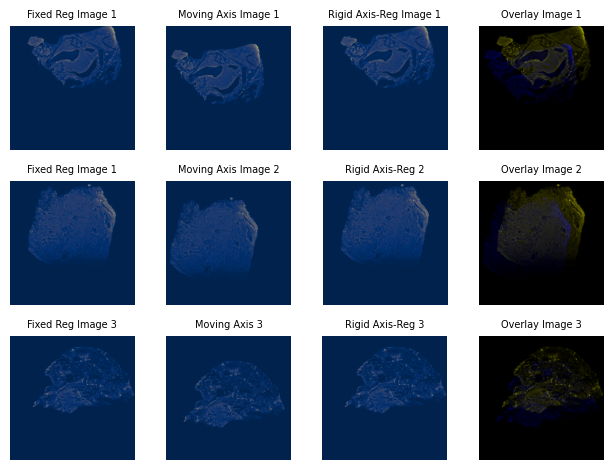

In [92]:
# Visualize the results
plt.subplot(3,4,1)
plt.imshow(rigid_transformed_image_4.numpy(),cmap='cividis')  
plt.title('Fixed Reg Image 1',fontsize=7)
plt.axis('off')

plt.subplot(3,4,2)
plt.imshow(axis_image_cropped_ants_4_padded.numpy(),cmap='cividis')  
plt.title('Moving Axis Image 1',fontsize=7)
plt.axis('off')

plt.subplot(3,4,3)
plt.imshow(rigid_result_4['warpedmovout'].numpy(),cmap='cividis')  
plt.title('Rigid Axis-Reg Image 1',fontsize=7)
plt.axis('off')

#Overlay for the first image
plt.subplot(3, 4, 4)
fixed_1 = exposure.rescale_intensity(rigid_transformed_image_4.numpy(), out_range=(0, 1))
moving_1 = exposure.rescale_intensity(axis_image_cropped_ants_4_padded.numpy(), out_range=(0, 1))
registered_1 = exposure.rescale_intensity(rigid_result_4['warpedmovout'].numpy(), out_range=(0, 1))
overlay_1 = np.stack([fixed_1, registered_1, moving_1], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_1)
plt.title('Overlay Image 1', fontsize=7)
plt.axis('off')

plt.subplot(3,4,5)
plt.imshow(rigid_transformed_image_5.numpy(),cmap='cividis')  
plt.title('Fixed Reg Image 1',fontsize=7)
plt.axis('off')

plt.subplot(3,4,6)
plt.imshow(axis_image_cropped_ants_5_padded.numpy(),cmap='cividis')  
plt.title('Moving Axis Image 2', fontsize=7)
plt.axis('off')

plt.subplot(3,4,7)
plt.imshow(rigid_result_5['warpedmovout'].numpy(),cmap='cividis')  
plt.title('Rigid Axis-Reg 2',fontsize=7)
plt.axis('off')

#Overlay for the second image
plt.subplot(3, 4, 8)
fixed_2 = exposure.rescale_intensity(rigid_transformed_image_5.numpy(), out_range=(0, 1))
moving_2 = exposure.rescale_intensity(axis_image_cropped_ants_5_padded.numpy(), out_range=(0, 1))
registered_2 = exposure.rescale_intensity(rigid_result_5['warpedmovout'].numpy(), out_range=(0, 1))
overlay_2 = np.stack([fixed_2, registered_2, moving_2], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_2)
plt.title('Overlay Image 2', fontsize=7)
plt.axis('off')

plt.subplot(3,4,9)
plt.imshow(rigid_transformed_image_6.numpy(),cmap='cividis')  
plt.title('Fixed Reg Image 3',fontsize=7)
plt.axis('off')

plt.subplot(3,4,10)
plt.imshow(axis_image_cropped_ants_6_padded.numpy(),cmap='cividis')  
plt.title('Moving Axis 3',fontsize=7)
plt.axis('off')

plt.subplot(3,4,11)
plt.imshow(rigid_result_6['warpedmovout'].numpy(),cmap='cividis')  
plt.title('Rigid Axis-Reg 3',fontsize=7)
plt.axis('off')

#Overlay for the third image
plt.subplot(3,4,12)
fixed_3 = exposure.rescale_intensity(rigid_transformed_image_6.numpy(), out_range=(0, 1))
moving_3 = exposure.rescale_intensity(axis_image_cropped_ants_6_padded.numpy(), out_range=(0, 1))
registered_3 = exposure.rescale_intensity(rigid_result_6['warpedmovout'].numpy(), out_range=(0, 1))
overlay_3 = np.stack([fixed_3, registered_3, moving_3], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_3)
plt.title('Overlay Image 3', fontsize=7)
plt.axis('off')

plt.tight_layout()  
plt.show()


In [109]:
rigid_result_4 #This is the result of the rigid registration

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -64.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-64.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image4_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image4_0GenericAffine.mat']}

In [110]:
rigid_result_5

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -64.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-64.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image5_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image5_0GenericAffine.mat']}

In [111]:
rigid_result_6

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -64.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-64.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image6_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image6_0GenericAffine.mat']}

In [112]:
fwd_aff_4 = ants.read_transform(rigid_result_4['fwdtransforms'][0])
fwd_aff_4_parameters_np = np.array(fwd_aff_4.parameters)
fwd_aff_4_parameters_np

array([ 0.99822366,  0.05957771, -0.05957771,  0.99822366,  2.56856155,
       11.42338562])

In [113]:
fwd_aff_4.fixed_parameters

array([115.42973328, 218.6615448 ])

In [115]:
fwd_aff_5 = ants.read_transform(rigid_result_5['fwdtransforms'][0])
fwd_aff_5_parameters_np = np.array(fwd_aff_5.parameters)
fwd_aff_5_parameters_np

array([ 9.99992013e-01,  3.99612123e-03, -3.99612123e-03,  9.99992013e-01,
       -9.65154552e+00,  6.79183960e+00])

In [117]:
fwd_aff_5.fixed_parameters

array([168.8303833, 201.3110199])

In [118]:
fwd_aff_6 = ants.read_transform(rigid_result_6['fwdtransforms'][0])
fwd_aff_6_parameters_np = np.array(fwd_aff_6.parameters)
fwd_aff_6_parameters_np

array([ 9.99936044e-01, -1.13113541e-02,  1.13113541e-02,  9.99936044e-01,
       -5.42118025e+00,  4.09160614e+01])

In [119]:
fwd_aff_6.fixed_parameters

array([200.70407104, 225.44619751])

In [120]:
#Metrics

# Compute mutual information
mi4 = ants.image_mutual_information(rigid_transformed_image_4, rigid_result_4['warpedmovout'])
mi5 = ants.image_mutual_information(rigid_transformed_image_5, rigid_result_5['warpedmovout'])
mi6 = ants.image_mutual_information(rigid_transformed_image_6, rigid_result_6['warpedmovout'])

# Compute normalized cross-correlation
cc4 = ants.math.image_similarity(rigid_transformed_image_4,  rigid_result_4['warpedmovout'], 'Correlation')
cc5 = ants.math.image_similarity(rigid_transformed_image_5, rigid_result_5['warpedmovout'], 'Correlation')
cc6 = ants.math.image_similarity(rigid_transformed_image_6,  rigid_result_6['warpedmovout'], 'Correlation')

# Compute mean squares
mse4 = ants.math.image_similarity(rigid_transformed_image_4,  rigid_result_4['warpedmovout'], 'MeanSquares')
mse5 = ants.math.image_similarity(rigid_transformed_image_5,  rigid_result_5['warpedmovout'], 'MeanSquares')
mse6 = ants.math.image_similarity(rigid_transformed_image_6, rigid_result_6['warpedmovout'], 'MeanSquares')


In [139]:
# Binarize the arrays (threshold = 0.5)


rigid_transformed_image_4_binary = (rigid_transformed_image_4.numpy() > 0.5).astype(int)
rigid_transformed_image_5_binary = (rigid_transformed_image_5.numpy() > 0.5).astype(int)
rigid_transformed_image_6_binary = (rigid_transformed_image_6.numpy() > 0.5).astype(int)

rigid_result_4_binary = (rigid_result_4['warpedmovout'].numpy() > 0.5).astype(int)
rigid_result_5_binary = (rigid_result_5['warpedmovout'].numpy() > 0.5).astype(int)
rigid_result_6_binary = (rigid_result_6['warpedmovout'].numpy() > 0.5).astype(int)


# Compute Jaccard Index
jaccard_4 = jaccard_score(rigid_transformed_image_4_binary.flatten(), rigid_result_4_binary.flatten())
jaccard_5 = jaccard_score(rigid_transformed_image_5_binary.flatten(), rigid_result_5_binary.flatten())  
jaccard_6 = jaccard_score(rigid_transformed_image_6_binary.flatten(), rigid_result_6_binary.flatten())


# Compute Dice Similarity Score

dice4 = f1_score(rigid_transformed_image_4_binary.flatten(), rigid_result_4_binary.flatten())
dice5 = f1_score(rigid_transformed_image_5_binary.flatten(), rigid_result_5_binary.flatten())
dice6 = f1_score(rigid_transformed_image_6_binary.flatten(), rigid_result_6_binary.flatten())


# Compute Hausdorff Distance using SimpleITK
sitk_initial_image_4 = sitk.GetImageFromArray(rigid_transformed_image_4.numpy())
sitk_final_image_4 = sitk.GetImageFromArray(rigid_result_4['warpedmovout'].numpy())

sitk_initial_image_5 = sitk.GetImageFromArray(rigid_transformed_image_5.numpy())
sitk_final_image_5 = sitk.GetImageFromArray(rigid_result_5['warpedmovout'].numpy())

sitk_initial_image_6 = sitk.GetImageFromArray(rigid_transformed_image_6.numpy())
sitk_final_image_6 = sitk.GetImageFromArray(rigid_result_6['warpedmovout'].numpy())

# Compute Hausdorff Distance for axis image 1 and final image 1
hausdorff_filter_4 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_4.Execute(sitk_initial_image_4, sitk_final_image_4)
hausdorff_sitk_4 = hausdorff_filter_4.GetHausdorffDistance()

hausdorff_filter_5 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_5.Execute(sitk_initial_image_5, sitk_final_image_5)
hausdorff_sitk_5 = hausdorff_filter_5.GetHausdorffDistance()

hausdorff_filter_6 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_6.Execute(sitk_initial_image_6, sitk_final_image_6)
hausdorff_sitk_6 = hausdorff_filter_6.GetHausdorffDistance()



<Figure size 1000x600 with 0 Axes>

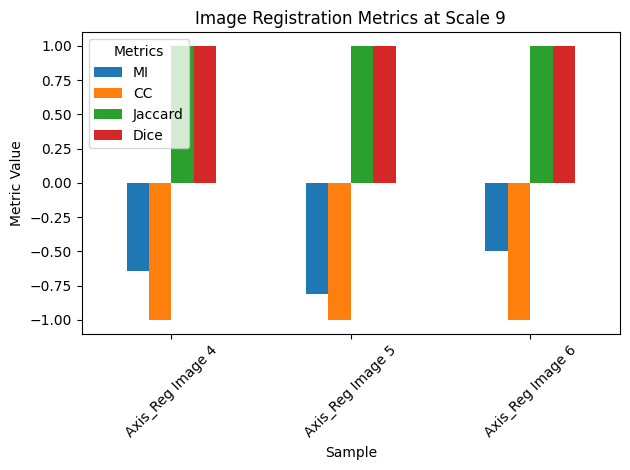

<Figure size 1000x600 with 0 Axes>

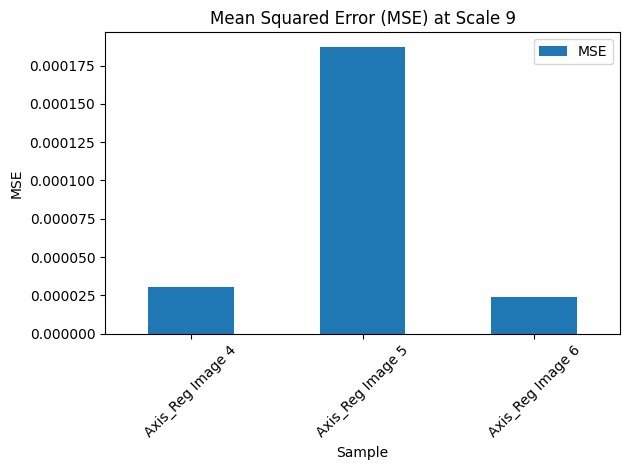

<Figure size 1000x600 with 0 Axes>

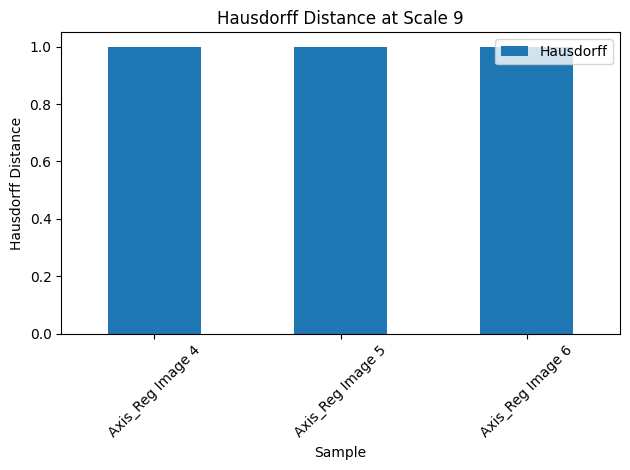

In [145]:
#Display the mi, cc, mse, jaccard, dice and hausdorff distance as graphs
metrics_df = pd.DataFrame({
    'Sample': ['Axis_Reg Image 4', 'Axis_Reg Image 5', 'Axis_Reg Image 6'],
    'MI': [mi4, mi5, mi6],
    'CC': [cc4, cc5, cc6],
    'MSE': [mse4, mse5, mse6],
    'Jaccard': [jaccard_4, jaccard_5, jaccard_6],
    'Dice': [dice4, dice5, dice6],
    'Hausdorff': [hausdorff_sitk_4, hausdorff_sitk_5, hausdorff_sitk_6]
})

# Set the index to the Sample ID
metrics_df.set_index('Sample', inplace=True)

# Plot the metrics minus hausdorff distance and mse
plt.figure(figsize=(10, 6))
metrics_df[['MI', 'CC', 'Jaccard', 'Dice']].plot(kind='bar')
plt.title('Image Registration Metrics at Scale 9')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

# Plot the Mean Squared Error (MSE)
plt.figure(figsize=(10, 6))
metrics_df[['MSE']].plot(kind='bar')
plt.title('Mean Squared Error (MSE) at Scale 9')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Plot the Hausdorff distance
plt.figure(figsize=(10, 6))
metrics_df[['Hausdorff']].plot(kind='bar')
plt.title('Hausdorff Distance at Scale 9')
plt.ylabel('Hausdorff Distance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [140]:
#Create dataframe to store the results

# Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 3 different slices representing the same tissue stained with the axis, regression and tbet panels
#Each different row represents a different tissue

row_1 = pd.DataFrame([results[0]])
row_2 = pd.DataFrame([results[1]])
row_3 = pd.DataFrame([results[2]])
                              

# Concatenate the rows into a single DataFrame
merged_df_2 = pd.concat([row_1, row_2, row_3], ignore_index=True)

#Add columns to the merged DataFrame

merged_df_2['scale'] = [7,7,7]
merged_df_2['final_image_fixed_parameters'] = [fwd_aff_4.fixed_parameters,fwd_aff_5.fixed_parameters,fwd_aff_6.fixed_parameters] 
merged_df_2['final_image_parameters'] = [fwd_aff_4.parameters,fwd_aff_5.parameters,fwd_aff_6.parameters] 
merged_df_2['mi_reg_transformed_axis'] = [mi4,mi5,mi6]
merged_df_2['cc_reg_transformed_axis'] = [cc4,cc5,cc6]
merged_df_2['mse_reg_transformed_axis'] = [mse4,mse5,mse6]
merged_df_2['jaccard_reg_transformed_axis'] = [jaccard_4,jaccard_5,jaccard_6]
merged_df_2['dice_reg_transformed_axis'] = [dice4,dice5,dice6]
merged_df_2['hausdorff_reg_transformed_axis'] = [hausdorff_sitk_4,hausdorff_sitk_5,hausdorff_sitk_6]


  




In [141]:
merged_df_2

,axis_sampleid,reg_sampleid,tbet_sampleid,slideid,reg_slideid,tbet_slideid,scale,final_image_fixed_parameters,final_image_parameters,mi_reg_transformed_axis,cc_reg_transformed_axis,mse_reg_transformed_axis,jaccard_reg_transformed_axis,dice_reg_transformed_axis,hausdorff_reg_transformed_axis
0,101,709,834,L1_2,LY1,AP0140001,7,"[115.42973327636719, 218.6615447998047]","[0.9982236623764038, 0.059577714651823044, -0....",-0.640391,-0.999993,0.000031,0.999462,0.999731,1.0
1,107,710,835,L2_4,LY2,AP0140002,7,"[168.83038330078125, 201.31101989746094]","[0.9999920129776001, 0.003996121231466532, -0....",-0.811161,-0.999920,0.000187,0.998606,0.999303,1.0
2,535,712,837,L4_3,LY4,AP0140004,7,"[200.70407104492188, 225.44619750976562]","[0.999936044216156, -0.011311354115605354, 0.0...",-0.494623,-0.999992,0.000024,0.999123,0.999561,1.0


In [142]:
merged_df.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_axis_scale_7.csv', index=False)

In [ ]:
#One matrix should be zeros as it the one being registered to the other. 
#Two tables one for axis and one for tbet. Tbet to regression and axis to regression
#Rigid registration at resolutions 9 and 7 (one pipeline), then affine at 5 and 3 (2nd pipeline), then deformable at 1
#Show similarity metrics at each step 
#Similarity metrics from transformed axis to regression. Transformed tbet to regression. Transformed axis to tbet (could be to validate registration)
#Talk about different registration methods compared to ANTsPy (e.g., STAlign, Sckit-image) why ANTsPy was chosen.
#Focus on 2-3 sets of images for use case

In [ ]:
#Is there any need for coordinate registration with STAlign since the images have spatial data?
#Should I repeat the process for each of the resolutions for each indiividual image? 
#Save transformation matrix
# Need to find a way to register the images at each resolution level by taking the registration result from the previous level as the initial transformation for the next level



#Should I also repeat the process for the other images in the database? Can I pick a handful of images to register?
#https://github.com/ANTsX/ANTsPy/blob/master/tutorials/concatenateRegistrations.ipynb 
#https://github.com/AstroPathJHU/WSIMIR 

In [ ]:

#Sources:

# https://pmc.ncbi.nlm.nih.gov/articles/PMC7584382/

#https://pubmed.ncbi.nlm.nih.gov/38632390/ 

#https://www.nature.com/articles/s41598-021-87564-6 

#Multi-resolution registration:
#https://discourse.itk.org/t/multiresolution-registration-with-2d-affine-transformation-on-pairs-of-2d-images/3096/10